In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import cv2 as cv2

import torch
import torch.hub

import torchvision
import torchvision.utils

from data import dataset as data
import data.utils as data_utils
import attack_construction.attack_methods as attack_methods
import attack_construction.metrics as metrics
import attack_construction.utils as attack_utils

print(torch.__version__)
print(torch.cuda_version)
print(torchvision.__version__)

IndentationError: unindent does not match any outer indentation level (metrics.py, line 103)

In [2]:
#device = torch.device("cpu")
device = torch.device("cuda:0")

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model.eval()
model = model.float().to(device)

for param in model.parameters():
    param.requires_grad = False

dataset = data.AdversarialDataset((640,640)) # todo: use resize to pull picture in batch

batch_size = 1

train_loader  = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [18]:
patch = attack_methods.generate_random_patch()
patch = patch.to(device)
patch.requires_grad = True

augmentations = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.05),
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.3)),
        torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        torchvision.transforms.RandomRotation(degrees=(-30, 30)),])

In [20]:
variation_coef = pow(10, -11)
grad_rate = 0.03
epoches = 1

def loss_function(predict, patch, device):
        return metrics.general_objectness(predict, device) + variation_coef * metrics.total_variation(patch)

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

for epoch in range(epoches):
    image_counter = 0

    for images, labels in train_loader:
        image_counter += batch_size

        cv2.imshow("patch", cv2.cvtColor(cv2.resize(data_utils.tensor_to_image(patch.clone().detach().cpu())/255, (300,300)), cv2.COLOR_RGB2BGR))

        loss, patch = attack_methods.training_step(model, patch, augmentations, images, labels, loss_function, device, grad_rate)
            
        print(f"ep:{epoch}, epoch_progress:{image_counter/len(dataset)}, batch_loss:{loss}")

        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows() 
            attack_utils.save_tensor(patch.cpu(), "patch - new")
            raise StopExecution


ep: 0 epoch_progress: 8.45401438873249e-06 loss: 2.4535382
ep: 0 epoch_progress: 1.690802877746498e-05 loss: 3.5559125
ep: 0 epoch_progress: 2.536204316619747e-05 loss: 2.453543


StopExecution: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


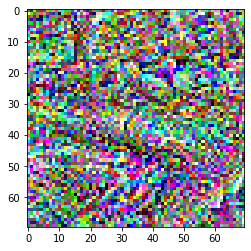

In [17]:
torch.cuda.empty_cache()
cv2.destroyAllWindows() 
attack_utils.show_tensor(patch.cpu())

In [8]:
#image, label = dataset[personIndex[7]]
#network parameters requar. grad

In [16]:
patch = attack_utils.load_tensor("patch 40%")

In [1]:
attack_utils.save_tensor(patch.cpu(), "patch - meme")

NameError: name 'attack_utils' is not defined

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch

import attack_construction.metrics as metrics


In [53]:
patch = torch.rand(3, 100, 100)
#print(patch)

metrics.printability_loss(patch)

tensor(0.0795)